In [1]:
import matplotlib.pyplot as plt

image_file = 'images/field-pic-1.png'

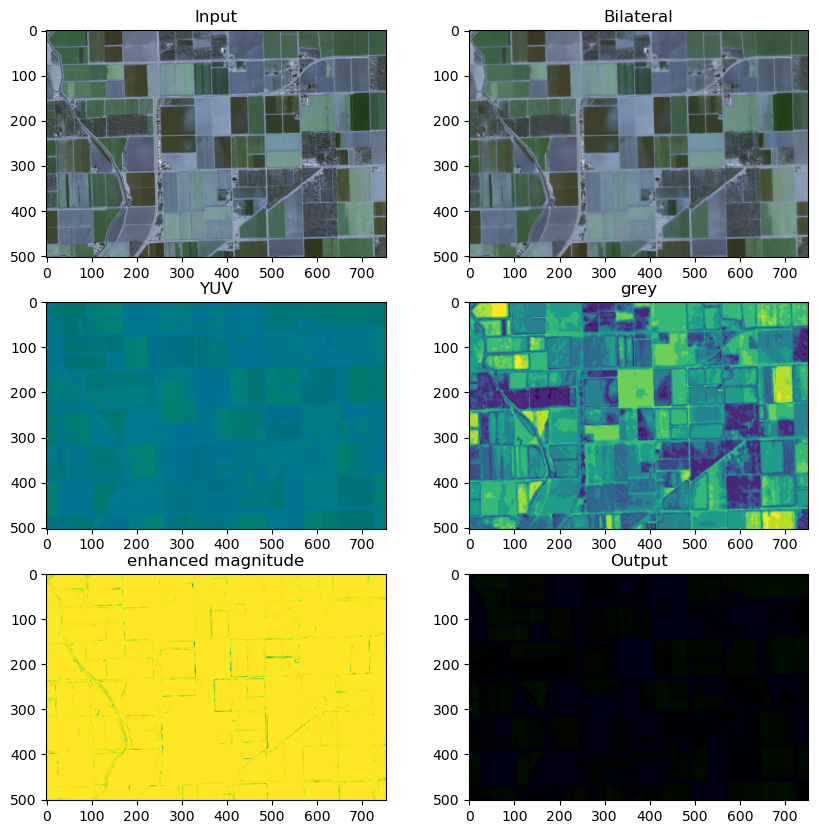

In [2]:
import cv2
import numpy as np

# Load your image
image = cv2.imread(image_file)

# Image Pre-Processing
# Apply bilateral filtering for noise reduction and edge preservation
bilateral_filtered_image = cv2.bilateralFilter(image, d=9, sigmaColor=75, sigmaSpace=75)

# Convert the image to YUV color space
yuv_image = cv2.cvtColor(bilateral_filtered_image, cv2.COLOR_BGR2YUV)

# Apply sigmoid transformation to enhance contrast
def sigmoid(x, alpha, x0):
    return 1 / (1 + np.exp(-alpha * (x - x0)))

alpha_sigmoid = 1.0  # You can adjust this value
x0_sigmoid = 128.0   # You can adjust this value
yuv_image[:, :, 0] = sigmoid(yuv_image[:, :, 0], alpha_sigmoid, x0_sigmoid)

# Convert the enhanced image back to RGB
enhanced_image = cv2.cvtColor(yuv_image, cv2.COLOR_YUV2BGR)

# Edge Detection
# Convert the enhanced image to grayscale
gray_image = cv2.cvtColor(enhanced_image, cv2.COLOR_BGR2GRAY)

# Apply Sobel operator for gradient calculation
gradient_x = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=3)
gradient_y = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize=3)

# Calculate gradient magnitude and direction
gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
gradient_direction = np.arctan2(gradient_y, gradient_x)

# Apply Meijering filter to enhance edge features
def meijering_filter(image):
    return (image ** 2) * (3 - 2 * image)

enhanced_gradient_magnitude = meijering_filter(gradient_magnitude)

# Seed Point Selection (You will need to implement this based on your requirements)

# Graph-Based Growing Contours (You will need to implement this based on your requirements)

# Polygon Creation and Post-Processing (You will need to implement this based on your requirements)

# Display or save the final result
plt.figure(figsize=[10, 10])
ax=plt.subplot(3,2,1)
ax.set_title("Input")
plt.imshow(image)

ax=plt.subplot(3,2,2)
ax.set_title("Bilateral")
plt.imshow(bilateral_filtered_image)

ax=plt.subplot(3,2,3)
ax.set_title("YUV")
plt.imshow(yuv_image)

ax=plt.subplot(3,2,4)
ax.set_title("grey")
plt.imshow(gray_image)

ax=plt.subplot(3,2,5)
ax.set_title("enhanced magnitude")
plt.imshow(enhanced_gradient_magnitude)

ax=plt.subplot(3,2,6)
ax.set_title("Output")
plt.imshow(enhanced_image)
plt.show()

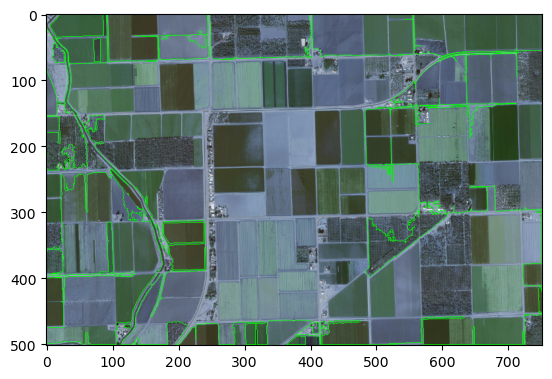

In [3]:
import cv2
import numpy as np

def graph_grwoing(image):
    # Define the size of the image tiles (50x50 pixels)
    tile_size = (50, 50)

    # Create a mask for the segmented region
    mask = np.zeros_like(image)

    # Define the threshold for region growing
    threshold = 30

    # Define the step size for moving the seed points
    step_x = tile_size[0]
    step_y = tile_size[1]

    # Iterate over the image in tiles
    for y in range(0, image.shape[0], step_y):
        for x in range(0, image.shape[1], step_x):
            # Seed point selection for each tile (center of the tile)
            seed_x = x + tile_size[0] // 2
            seed_y = y + tile_size[1] // 2

            # Initialize the stack for graph-based growing
            stack = [(seed_x, seed_y)]

            while stack:
                x, y = stack.pop()

                # Check if the pixel is within the image boundaries
                if 0 <= x < image.shape[1] and 0 <= y < image.shape[0]:
                    # Check if the pixel is not already part of the segmented region
                    if mask[y, x].all() == 0:
                        # Check the intensity difference between the seed pixel and the current pixel
                        diff = np.abs(image[y, x].astype(int) - image[seed_y, seed_x].astype(int))

                        # If the difference is below the threshold, add the pixel to the region
                        if np.all(diff < threshold):
                            mask[y, x] = [255, 255, 255]  # Mark the pixel as part of the region
                            stack.append((x + 1, y))
                            stack.append((x - 1, y))
                            stack.append((x, y + 1))
                            stack.append((x, y - 1))

    # Find contours in the mask
    contours, _ = cv2.findContours(cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw the contours on the original image
    output = image.copy()
    cv2.drawContours(output, contours, -1, (0, 255, 0), 1)  # Green contours
    return output

image = cv2.imread(image_file)
output = graph_grwoing(image)
plt.imshow(output)

# Holistically Nested Edge Detection

## Load the Model:

In [4]:
# !git clone git@github.com:ashukid/hed-edge-detector.git

In [5]:
# import os
# os.chdir('hed-edge-detector')

In [6]:
# !python edge_detector.py --input ..\\images\\field-pic-1.png --prototxt deploy.prototxt --caffemodel hed_pretrained_bsds.caffemodel  --width 700 --height 500
# image = cv2.imread("out.jpg")
# plt.imshow(image)

In [7]:
import numpy as np
class CropLayer(object):
    def __init__(self, params, blobs):
        self.xstart = 0
        self.xend = 0
        self.ystart = 0
        self.yend = 0

    # Our layer receives two inputs. We need to crop the first input blob
    # to match a shape of the second one (keeping batch size and number of channels)
    def getMemoryShapes(self, inputs):
        inputShape, targetShape = inputs[0], inputs[1]
        batchSize, numChannels = inputShape[0], inputShape[1]
        height, width = targetShape[2], targetShape[3]

        self.ystart = int((inputShape[2] - targetShape[2]) / 2)
        self.xstart = int((inputShape[3] - targetShape[3]) / 2)
        self.yend = self.ystart + height
        self.xend = self.xstart + width

        return [[batchSize, numChannels, height, width]]

    def forward(self, inputs):
        return [inputs[0][:, :, self.ystart:self.yend, self.xstart:self.xend]]
# Load the model.
net = cv2.dnn.readNetFromCaffe("hed-edge-detector\\deploy.prototxt", "hed-edge-detector\\hed_pretrained_bsds.caffemodel")
cv2.dnn_registerLayer('Crop', CropLayer)

def hed(image):
    width, height, c = image.shape

    # image = cv2.imread(args.input)
    # image = cv2.resize(image, (args.width, args.height))

    inp = cv2.dnn.blobFromImage(image, scalefactor=1.0, size=(width, height),
                               mean=(104.00698793, 116.66876762, 122.67891434),
                               swapRB=False, crop=False)
    net.setInput(inp)
    # edges = cv2.Canny(image,image.shape[1],image.shape[0])
    out = net.forward()

    out = out[0, 0]
    out = cv2.resize(out, (image.shape[1], image.shape[0]))

    # print(out.shape)
    out = cv2.cvtColor(out, cv2.COLOR_GRAY2BGR)
    out = 255 * out
    out = out.astype(np.uint8)
    
    return out

In [8]:
def dehaze(image, omega=0.95, tmin=0.1):
    # Calculate the dark channel of the image
    min_channel = np.min(image, axis=2)

    # Estimate the atmospheric light using the top 'omega' percentage of brightest pixels
    num_pixels = min_channel.size
    num_brightest = int(num_pixels * omega)
    flat_dark_channel = min_channel.flatten()
    indices = np.argpartition(flat_dark_channel, -num_brightest)[-num_brightest:]
    atmospheric_light = np.max(image.reshape(-1, 3)[indices], axis=0)

    # Calculate the transmission map
    transmission = 1 - omega * min_channel / np.max(atmospheric_light)

    # Clip transmission values to ensure they are not too small
    transmission = np.maximum(transmission, tmin)

    # Estimate the scene radiance
    scene_radiance = np.zeros_like(image, dtype=np.float32)
    for i in range(3):
        scene_radiance[:, :, i] = (image[:, :, i] - atmospheric_light[i]) / transmission + atmospheric_light[i]

    scene_radiance = np.clip(scene_radiance, 0, 255)

    return scene_radiance

def sharpen_image(image, sigma=1.0, alpha=1.5):
    blurred = cv2.GaussianBlur(image, (0, 0), sigma)
    sharpened = cv2.addWeighted(image, alpha + 1, blurred, -alpha, 0)
    return sharpened

def fft_edge(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Perform FFT
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)

    # Define a high-pass filter mask
    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2
    mask = np.zeros((rows, cols), np.uint8)
    mask[crow - 30:crow + 30, ccol - 30:ccol + 30] = 1

    # Apply the high-pass filter
    fshift_filtered = fshift * mask

    # Perform Inverse FFT
    f_ishift = np.fft.ifftshift(fshift_filtered)
    image_back = np.fft.ifft2(f_ishift)
    image_back = np.abs(image_back)

    # Normalize the result to 8-bit for display
    edge_detected = cv2.normalize(image_back, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Apply thresholding to get binary edges
    _, edges = cv2.threshold(edge_detected, 50, 255, cv2.THRESH_BINARY)
    return edges

In [9]:
inpimg = cv2.imread(image_file)
image = hed(inpimg)


kernel = np.ones((5, 5), np.uint8)
closing_result = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)

dhz = dehaze(image)
srp = sharpen_image(sharpen_image(sharpen_image(image)))
ggs = graph_grwoing(srp)
fft = fft_edge(image)


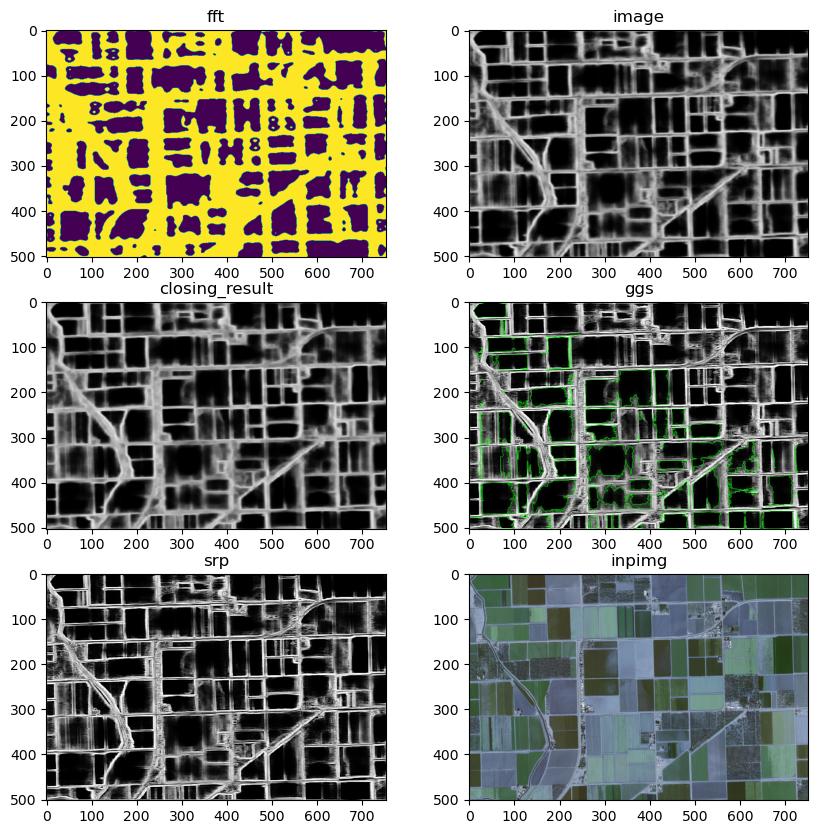

In [10]:
# Display or save the final result
plt.figure(figsize=[10, 10])
ax=plt.subplot(3,2,1)
ax.set_title("fft")
plt.imshow(fft)

ax=plt.subplot(3,2,2)
ax.set_title("image")
plt.imshow(image)

ax=plt.subplot(3,2,3)
ax.set_title("closing_result")
plt.imshow(closing_result)

ax=plt.subplot(3,2,4)
ax.set_title("ggs")
plt.imshow(ggs)

ax=plt.subplot(3,2,5)
ax.set_title("srp")
plt.imshow(srp)

ax=plt.subplot(3,2,6)
ax.set_title("inpimg")
plt.imshow(inpimg)
plt.show()

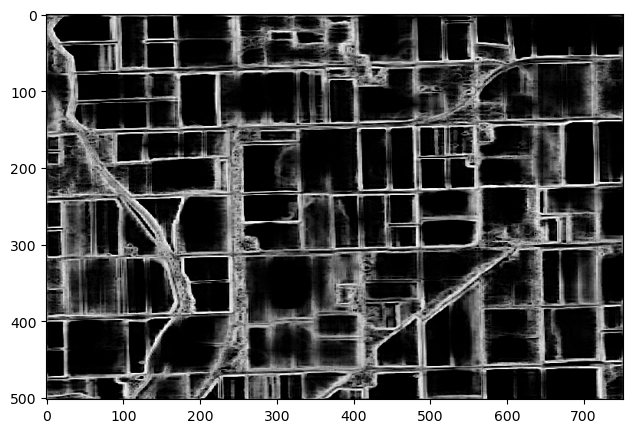

In [11]:
srp = image.copy()
times = 3
for i in range(times):
    srp = sharpen_image(srp)

    # Define a kernel (structuring element)
kernel = np.ones((2, 2), np.uint8)  # You can customize the size and shape of the kernel

# Perform erosion
srp = cv2.erode(srp, kernel, iterations=1)

# # Apply Gaussian blur to reduce noise (optional but recommended)
# blurred = cv2.GaussianBlur(srp, (5, 5), 0)

# # Perform Canny edge detection
# edges = cv2.Canny(blurred, threshold1=30, threshold2=100)

plt.figure(figsize=[10,5])
plt.imshow(srp)